# Testing U-net testing

Testing U-net with a few examples implemented with Keras
Data set from data science bowl 2018

In [1]:
import numpy as np
import os
import sys
import random
import warnings

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


### Parameters

In [2]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [10]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print(X_train.shape)
print(Y_train.shape)

(670, 128, 128, 3)
(670, 128, 128, 1)


In [11]:

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [02:39<00:00,  4.21it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 80.65it/s]

Done!


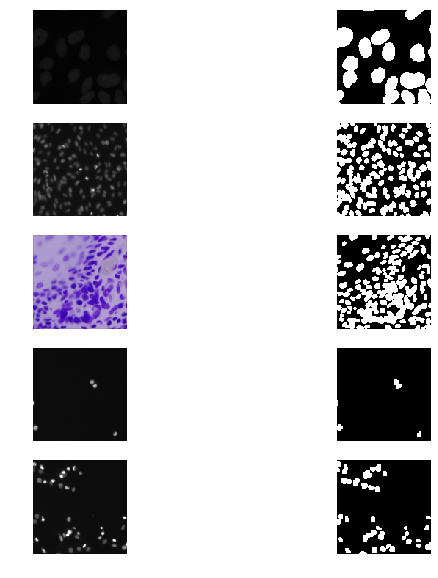

In [5]:
n_images = 5
fig, axes = plt.subplots(n_images,2,figsize=(10,10))
for i in range(n_images):
    ix = random.randint(0, len(train_ids))
    axes[i,0].imshow(X_train[ix])
    axes[i,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')

fig = plt.gcf()
for ax in fig.axes:
    ax.axis('off')

plt.show()

### IoU (Intersection of the union)

In [6]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

## U-Net

In [7]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
________________________________________________________________________________________________

### Test Model with 100 images

In [15]:
limit = 100

checkpointer = ModelCheckpoint('model-unet-dsbowl2018-201905_100.h5', verbose=1, save_best_only=True)


results = model.fit(X_train[:limit], Y_train[:limit], validation_split=0.1, batch_size=5, epochs=40, 
                    callbacks=[checkpointer])

Train on 90 samples, validate on 10 samples
Epoch 1/40
90/90 [==============================] - 0s 4ms/step - loss: 0.0927 - mean_iou: 0.7976 - val_loss: 0.0980 - val_mean_iou: 0.7988

Epoch 00001: val_loss improved from inf to 0.09801, saving model to model-unet-dsbowl2018-201905_100.h5
Epoch 2/40
90/90 [==============================] - 0s 3ms/step - loss: 0.0888 - mean_iou: 0.8000 - val_loss: 0.0934 - val_mean_iou: 0.8010

Epoch 00002: val_loss improved from 0.09801 to 0.09340, saving model to model-unet-dsbowl2018-201905_100.h5
Epoch 3/40
90/90 [==============================] - 0s 3ms/step - loss: 0.0913 - mean_iou: 0.8020 - val_loss: 0.1098 - val_mean_iou: 0.8031

Epoch 00003: val_loss did not improve from 0.09340
Epoch 4/40
90/90 [==============================] - 0s 3ms/step - loss: 0.1112 - mean_iou: 0.8039 - val_loss: 0.1081 - val_mean_iou: 0.8044

Epoch 00004: val_loss did not improve from 0.09340
Epoch 5/40
90/90 [==============================] - 0s 3ms/step - loss: 0.0899

### Test Model with 200 images

In [16]:
limit = 200

checkpointer = ModelCheckpoint('model-unet-dsbowl2018-201905_200.h5', verbose=1, save_best_only=True)


results = model.fit(X_train[:limit], Y_train[:limit], validation_split=0.1, batch_size=5, epochs=40, 
                    callbacks=[checkpointer])

Train on 180 samples, validate on 20 samples
Epoch 1/40
180/180 [==============================] - 1s 3ms/step - loss: 0.0844 - mean_iou: 0.8532 - val_loss: 0.0733 - val_mean_iou: 0.8536

Epoch 00001: val_loss improved from inf to 0.07333, saving model to model-unet-dsbowl2018-201905_200.h5
Epoch 2/40
180/180 [==============================] - 1s 3ms/step - loss: 0.0773 - mean_iou: 0.8540 - val_loss: 0.0707 - val_mean_iou: 0.8545

Epoch 00002: val_loss improved from 0.07333 to 0.07073, saving model to model-unet-dsbowl2018-201905_200.h5
Epoch 3/40
180/180 [==============================] - 1s 3ms/step - loss: 0.0794 - mean_iou: 0.8548 - val_loss: 0.0832 - val_mean_iou: 0.8553

Epoch 00003: val_loss did not improve from 0.07073
Epoch 4/40
180/180 [==============================] - 1s 3ms/step - loss: 0.0796 - mean_iou: 0.8556 - val_loss: 0.0770 - val_mean_iou: 0.8560

Epoch 00004: val_loss did not improve from 0.07073
Epoch 5/40
180/180 [==============================] - 1s 3ms/step - l

### Test Model with 300 images

In [17]:
limit = 300

checkpointer = ModelCheckpoint('model-unet-dsbowl2018-201905_300.h5', verbose=1, save_best_only=True)


results = model.fit(X_train[:limit], Y_train[:limit], validation_split=0.1, batch_size=5, epochs=40, 
                    callbacks=[checkpointer])

Train on 270 samples, validate on 30 samples
Epoch 1/40
270/270 [==============================] - 1s 3ms/step - loss: 0.0667 - mean_iou: 0.8874 - val_loss: 0.0759 - val_mean_iou: 0.8875

Epoch 00001: val_loss improved from inf to 0.07593, saving model to model-unet-dsbowl2018-201905_300.h5
Epoch 2/40
270/270 [==============================] - 1s 3ms/step - loss: 0.0814 - mean_iou: 0.8875 - val_loss: 0.0895 - val_mean_iou: 0.8874

Epoch 00002: val_loss did not improve from 0.07593
Epoch 3/40
270/270 [==============================] - 1s 3ms/step - loss: 0.1025 - mean_iou: 0.8871 - val_loss: 0.0850 - val_mean_iou: 0.8870

Epoch 00003: val_loss did not improve from 0.07593
Epoch 4/40
270/270 [==============================] - 1s 3ms/step - loss: 0.0834 - mean_iou: 0.8869 - val_loss: 0.0808 - val_mean_iou: 0.8869

Epoch 00004: val_loss did not improve from 0.07593
Epoch 5/40
270/270 [==============================] - 1s 3ms/step - loss: 0.0750 - mean_iou: 0.8869 - val_loss: 0.0765 - val_m

## Predictions

In [18]:
# Predict on train, val and test
model = load_model('model-unet-dsbowl2018-201905_100.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 0s 1ms/step


### IMAGE |  MASK | PREDICTION

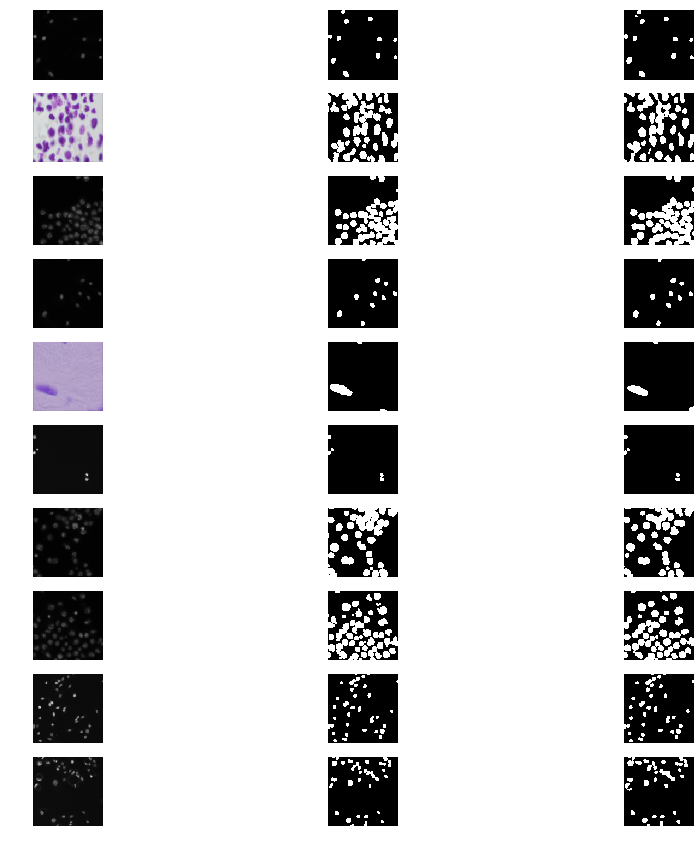

In [19]:
n_images = 10

fig, axes = plt.subplots(n_images,3,figsize=(15,15))

for i in range(n_images):
    ix = random.randint(0, len(preds_train_t-1))
    axes[i,0].imshow(X_train[ix])
    axes[i,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')
    axes[i,2].imshow(np.squeeze(preds_train_t[ix]), cmap='gray')

fig = plt.gcf()
for ax in fig.axes:
    ax.axis('off')

plt.show()